# Method 9 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

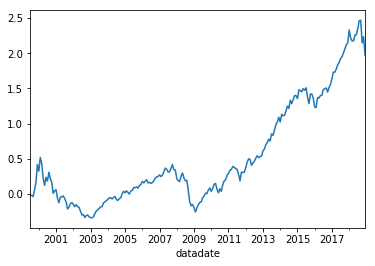

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.417504
2000-12-31   -0.265155
2001-12-31   -0.159650
2002-12-31   -0.232430
2003-12-31    0.344885
2004-12-31    0.146096
2005-12-31    0.091727
2006-12-31    0.101952
2007-12-31    0.074560
2008-12-31   -0.365779
2009-12-31    0.275769
2010-12-31    0.166039
2011-12-31    0.034378
2012-12-31    0.175721
2013-12-31    0.360989
2014-12-31    0.145966
2015-12-31   -0.015888
2016-12-31    0.084454
2017-12-31    0.233505
2018-12-31   -0.057061
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     456.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.82e-108
Time:                        21:18:14   Log-Likelihood:                 638.83
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.539      0.125      -0.000       0.004
mktrf          0.9060      0.030     30.454      0.000       0.847       0.965
me             0.2776      0.035      8.021      0.000       0.209       0.346
ia            -0.4840      0.053     -9.202      0.000      -0.588      -0.380
roe            0.1050      0.045      2.332      0.021       0.016       0.194
==============================================================================
Omnibus:                       99.650   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1702.340
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                      16.002   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     216.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-76
Time:                        21:18:14   Log-Likelihood:                 638.83
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.584      0.113      -0.000       0.004
mktrf          0.9060      0.037     24.562      0.000       0.834       0.978
me             0.2776      0.092      3.006      0.003       0.097       0.459
ia            -0.4840      0.126     -3.854      0.000      -0.730      -0.238
roe            0.1050      0.060      1.747      0.081      -0.013       0.223
==============================================================================
Omnibus:                       99.650   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1702.340
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                      16.002   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     298.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-89
Time:                        21:18:14   Log-Likelihood:                 638.83
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.640      0.101      -0.000       0.004
mktrf          0.9060      0.030     30.494      0.000       0.848       0.964
me             0.2776      0.099      2.792      0.005       0.083       0.472
ia            -0.4840      0.116     -4.159      0.000      -0.712      -0.256
roe            0.1050      0.051      2.059      0.040       0.005       0.205
==============================================================================
Omnibus:                       99.650   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1702.340
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                      16.002   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     397.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.26e-110
Time:                        21:18:14   Log-Likelihood:                 648.18
No. Observations:                 234   AIC:                            -1284.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.267      0.024       0.000       0.004
mktrf          0.8832      0.029     30.769      0.000       0.827       0.940
smb            0.2420      0.038      6.390      0.000       0.167       0.317
hml           -0.2646      0.045     -5.925      0.000      -0.353      -0.177
rmw           -0.0555      0.050     -1.099      0.273      -0.155       0.044
cma           -0.1199      0.064     -1.867      0.063      -0.246       0.007
==============================================================================
Omnibus:                       93.300   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1233.569
Skew:                           1.151   Prob(JB):                    1.36e-268
Kurtosis:                      14.010   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     704.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.07e-136
Time:                        21:18:15   Log-Likelihood:                 648.18
No. Observations:                 234   AIC:                            -1284.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.432      0.015       0.000       0.004
mktrf          0.8832      0.034     25.757      0.000       0.816       0.950
smb            0.2420      0.075      3.248      0.001       0.096       0.388
hml           -0.2646      0.075     -3.524      0.000      -0.412      -0.117
rmw           -0.0555      0.079     -0.698      0.485      -0.211       0.100
cma           -0.1199      0.145     -0.826      0.409      -0.404       0.165
==============================================================================
Omnibus:                       93.300   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1233.569
Skew:                           1.151   Prob(JB):                    1.36e-268
Kurtosis:                      14.010   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     812.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.11e-143
Time:                        21:18:15   Log-Likelihood:                 648.18
No. Observations:                 234   AIC:                            -1284.
Df Residuals:                     228   BIC:                            -1264.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.407      0.016       0.000       0.004
mktrf          0.8832      0.035     25.505      0.000       0.815       0.951
smb            0.2420      0.075      3.221      0.001       0.095       0.389
hml           -0.2646      0.081     -3.284      0.001      -0.423      -0.107
rmw           -0.0555      0.077     -0.722      0.470      -0.206       0.095
cma           -0.1199      0.150     -0.797      0.426      -0.415       0.175
==============================================================================
Omnibus:                       93.300   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1233.569
Skew:                           1.151   Prob(JB):                    1.36e-268
Kurtosis:                      14.010   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     704.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.17e-127
Time:                        21:18:15   Log-Likelihood:                 685.01
No. Observations:                 234   AIC:                            -1360.
Df Residuals:                     229   BIC:                            -1343.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.878      0.381      -0.001       0.002
mktrf          0.9994      0.022     44.448      0.000       0.955       1.044
smb            0.1888      0.028      6.727      0.000       0.133       0.244
hml           -0.2425      0.028     -8.698      0.000      -0.297      -0.188
umd            0.1709      0.018      9.344      0.000       0.135       0.207
==============================================================================
Omnibus:                       83.522   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.338
Skew:                           1.100   Prob(JB):                    1.18e-168
Kurtosis:                      11.630   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     283.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-87
Time:                        21:18:15   Log-Likelihood:                 685.01
No. Observations:                 234   AIC:                            -1360.
Df Residuals:                     229   BIC:                            -1343.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.007      0.314      -0.001       0.002
mktrf          0.9994      0.039     25.757      0.000       0.923       1.075
smb            0.1888      0.047      3.989      0.000       0.096       0.282
hml           -0.2425      0.044     -5.562      0.000      -0.328      -0.157
umd            0.1709      0.043      4.005      0.000       0.087       0.255
==============================================================================
Omnibus:                       83.522   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.338
Skew:                           1.100   Prob(JB):                    1.18e-168
Kurtosis:                      11.630   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.81e-85
Time:                        21:18:15   Log-Likelihood:                 685.01
No. Observations:                 234   AIC:                            -1360.
Df Residuals:                     229   BIC:                            -1343.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.106      0.269      -0.001       0.002
mktrf          0.9994      0.043     23.509      0.000       0.916       1.083
smb            0.1888      0.042      4.485      0.000       0.106       0.271
hml           -0.2425      0.040     -6.011      0.000      -0.322      -0.163
umd            0.1709      0.046      3.705      0.000       0.081       0.261
==============================================================================
Omnibus:                       83.522   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.338
Skew:                           1.100   Prob(JB):                    1.18e-168
Kurtosis:                      11.630   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     203.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.24e-51
Time:                        21:18:15   Log-Likelihood:                 300.79
No. Observations:                 120   AIC:                            -591.6
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.389      0.698      -0.003       0.005
mktrf          0.9218      0.052     17.743      0.000       0.819       1.025
me             0.3724      0.051      7.257      0.000       0.271       0.474
ia            -0.5714      0.080     -7.111      0.000      -0.731      -0.412
roe            0.1628      0.071      2.289      0.024       0.022       0.304
==============================================================================
Omnibus:                       47.029   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.358
Skew:                           1.109   Prob(JB):                     2.69e-65
Kurtosis:                      10.386   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     72.71
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-30
Time:                        21:18:15   Log-Likelihood:                 300.79
No. Observations:                 120   AIC:                            -591.6
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.394      0.694      -0.003       0.004
mktrf          0.9218      0.073     12.591      0.000       0.778       1.065
me             0.3724      0.092      4.057      0.000       0.192       0.552
ia            -0.5714      0.146     -3.902      0.000      -0.858      -0.284
roe            0.1628      0.073      2.236      0.025       0.020       0.305
==============================================================================
Omnibus:                       47.029   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.358
Skew:                           1.109   Prob(JB):                     2.69e-65
Kurtosis:                      10.386   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     84.12
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.09e-33
Time:                        21:18:15   Log-Likelihood:                 300.79
No. Observations:                 120   AIC:                            -591.6
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.443      0.657      -0.003       0.004
mktrf          0.9218      0.071     13.064      0.000       0.784       1.060
me             0.3724      0.099      3.744      0.000       0.177       0.567
ia            -0.5714      0.132     -4.325      0.000      -0.830      -0.312
roe            0.1628      0.057      2.868      0.004       0.052       0.274
==============================================================================
Omnibus:                       47.029   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.358
Skew:                           1.109   Prob(JB):                     2.69e-65
Kurtosis:                      10.386   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     174.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.99e-52
Time:                        21:18:15   Log-Likelihood:                 304.91
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     114   BIC:                            -581.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.350      0.180      -0.001       0.006
mktrf          0.8951      0.053     16.836      0.000       0.790       1.000
smb            0.3449      0.060      5.727      0.000       0.226       0.464
hml           -0.3146      0.074     -4.264      0.000      -0.461      -0.168
rmw            0.0183      0.087      0.210      0.834      -0.154       0.191
cma           -0.1471      0.095     -1.543      0.126      -0.336       0.042
==============================================================================
Omnibus:                       36.590   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.941
Skew:                           0.832   Prob(JB):                     6.32e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     239.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.14e-59
Time:                        21:18:15   Log-Likelihood:                 304.91
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     114   BIC:                            -581.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.430      0.153      -0.001       0.006
mktrf          0.8951      0.068     13.157      0.000       0.762       1.028
smb            0.3449      0.084      4.121      0.000       0.181       0.509
hml           -0.3146      0.093     -3.367      0.001      -0.498      -0.131
rmw            0.0183      0.080      0.229      0.819      -0.138       0.175
cma           -0.1471      0.195     -0.753      0.452      -0.530       0.236
==============================================================================
Omnibus:                       36.590   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.941
Skew:                           0.832   Prob(JB):                     6.32e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     232.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.41e-58
Time:                        21:18:15   Log-Likelihood:                 304.91
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     114   BIC:                            -581.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.362      0.173      -0.001       0.006
mktrf          0.8951      0.074     12.129      0.000       0.750       1.040
smb            0.3449      0.075      4.585      0.000       0.197       0.492
hml           -0.3146      0.102     -3.095      0.002      -0.514      -0.115
rmw            0.0183      0.070      0.259      0.795      -0.120       0.156
cma           -0.1471      0.204     -0.722      0.470      -0.546       0.252
==============================================================================
Omnibus:                       36.590   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.941
Skew:                           0.832   Prob(JB):                     6.32e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     385.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-65
Time:                        21:18:15   Log-Likelihood:                 335.48
No. Observations:                 120   AIC:                            -661.0
Df Residuals:                     115   BIC:                            -647.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.248      0.214      -0.001       0.005
mktrf          1.0665      0.034     31.112      0.000       0.999       1.134
smb            0.2094      0.039      5.364      0.000       0.132       0.287
hml           -0.2595      0.039     -6.639      0.000      -0.337      -0.182
umd            0.2174      0.024      9.019      0.000       0.170       0.265
==============================================================================
Omnibus:                       23.557   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.864
Skew:                           0.497   Prob(JB):                     9.25e-22
Kurtosis:                       7.288   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     162.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.67e-46
Time:                        21:18:15   Log-Likelihood:                 335.48
No. Observations:                 120   AIC:                            -661.0
Df Residuals:                     115   BIC:                            -647.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.391      0.164      -0.001       0.004
mktrf          1.0665      0.052     20.322      0.000       0.964       1.169
smb            0.2094      0.037      5.660      0.000       0.137       0.282
hml           -0.2595      0.043     -6.060      0.000      -0.343      -0.176
umd            0.2174      0.044      4.978      0.000       0.132       0.303
==============================================================================
Omnibus:                       23.557   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.864
Skew:                           0.497   Prob(JB):                     9.25e-22
Kurtosis:                       7.288   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     125.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-41
Time:                        21:18:15   Log-Likelihood:                 335.48
No. Observations:                 120   AIC:                            -661.0
Df Residuals:                     115   BIC:                            -647.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.573      0.116      -0.000       0.004
mktrf          1.0665      0.054     19.751      0.000       0.961       1.172
smb            0.2094      0.030      7.078      0.000       0.151       0.267
hml           -0.2595      0.034     -7.611      0.000      -0.326      -0.193
umd            0.2174      0.044      4.888      0.000       0.130       0.305
==============================================================================
Omnibus:                       23.557   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.864
Skew:                           0.497   Prob(JB):                     9.25e-22
Kurtosis:                       7.288   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     865.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-81
Time:                        21:18:15   Log-Likelihood:                 420.08
No. Observations:                 114   AIC:                            -830.2
Df Residuals:                     109   BIC:                            -816.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.764      0.007       0.000       0.003
mktrf          0.9428      0.018     51.631      0.000       0.907       0.979
me             0.0059      0.028      0.210      0.834      -0.050       0.062
ia            -0.2142      0.039     -5.476      0.000      -0.292      -0.137
roe            0.0826      0.034      2.403      0.018       0.014       0.151
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.693
Skew:                          -0.163   Prob(JB):                        0.707
Kurtosis:                       2.801   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1686.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.26e-97
Time:                        21:18:15   Log-Likelihood:                 420.08
No. Observations:                 114   AIC:                            -830.2
Df Residuals:                     109   BIC:                            -816.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.574      0.010       0.000       0.003
mktrf          0.9428      0.018     52.061      0.000       0.907       0.978
me             0.0059      0.040      0.148      0.882      -0.072       0.084
ia            -0.2142      0.041     -5.201      0.000      -0.295      -0.133
roe            0.0826      0.041      2.034      0.042       0.003       0.162
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.693
Skew:                          -0.163   Prob(JB):                        0.707
Kurtosis:                       2.801   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2465.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.07e-106
Time:                        21:18:15   Log-Likelihood:                 420.08
No. Observations:                 114   AIC:                            -830.2
Df Residuals:                     109   BIC:                            -816.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.311      0.021       0.000       0.003
mktrf          0.9428      0.018     53.415      0.000       0.908       0.977
me             0.0059      0.038      0.154      0.877      -0.069       0.081
ia            -0.2142      0.040     -5.404      0.000      -0.292      -0.136
roe            0.0826      0.037      2.212      0.027       0.009       0.156
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.693
Skew:                          -0.163   Prob(JB):                        0.707
Kurtosis:                       2.801   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     693.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-80
Time:                        21:18:15   Log-Likelihood:                 420.69
No. Observations:                 114   AIC:                            -829.4
Df Residuals:                     108   BIC:                            -813.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.539      0.127      -0.000       0.002
mktrf          0.9328      0.017     53.600      0.000       0.898       0.967
smb            0.0056      0.028      0.197      0.844      -0.050       0.062
hml           -0.1081      0.036     -3.001      0.003      -0.180      -0.037
rmw            0.0302      0.044      0.685      0.495      -0.057       0.118
cma           -0.1059      0.056     -1.890      0.061      -0.217       0.005
==============================================================================
Omnibus:                        2.048   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.891
Skew:                          -0.217   Prob(JB):                        0.388
Kurtosis:                       2.543   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2033.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.53e-105
Time:                        21:18:15   Log-Likelihood:                 420.69
No. Observations:                 114   AIC:                            -829.4
Df Residuals:                     108   BIC:                            -813.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.777      0.076   -9.85e-05       0.002
mktrf          0.9328      0.018     50.856      0.000       0.897       0.969
smb            0.0056      0.034      0.162      0.872      -0.062       0.073
hml           -0.1081      0.028     -3.907      0.000      -0.162      -0.054
rmw            0.0302      0.038      0.804      0.421      -0.043       0.104
cma           -0.1059      0.048     -2.203      0.028      -0.200      -0.012
==============================================================================
Omnibus:                        2.048   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.891
Skew:                          -0.217   Prob(JB):                        0.388
Kurtosis:                       2.543   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2579.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.35e-110
Time:                        21:18:15   Log-Likelihood:                 420.69
No. Observations:                 114   AIC:                            -829.4
Df Residuals:                     108   BIC:                            -813.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.676      0.094      -0.000       0.002
mktrf          0.9328      0.018     52.259      0.000       0.898       0.968
smb            0.0056      0.034      0.163      0.870      -0.061       0.072
hml           -0.1081      0.027     -3.963      0.000      -0.162      -0.055
rmw            0.0302      0.041      0.737      0.461      -0.050       0.111
cma           -0.1059      0.046     -2.299      0.022      -0.196      -0.016
==============================================================================
Omnibus:                        2.048   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.891
Skew:                          -0.217   Prob(JB):                        0.388
Kurtosis:                       2.543   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     853.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.93e-81
Time:                        21:18:15   Log-Likelihood:                 419.32
No. Observations:                 114   AIC:                            -828.6
Df Residuals:                     109   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.237      0.219      -0.000       0.002
mktrf          0.9369      0.017     53.780      0.000       0.902       0.971
smb           -0.0018      0.027     -0.067      0.947      -0.056       0.052
hml           -0.1449      0.028     -5.180      0.000      -0.200      -0.089
umd            0.0235      0.021      1.115      0.267      -0.018       0.065
==============================================================================
Omnibus:                        1.535   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.388
Skew:                          -0.134   Prob(JB):                        0.500
Kurtosis:                       2.531   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1387.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.79e-92
Time:                        21:18:15   Log-Likelihood:                 419.32
No. Observations:                 114   AIC:                            -828.6
Df Residuals:                     109   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.449      0.147      -0.000       0.002
mktrf          0.9369      0.020     45.775      0.000       0.897       0.977
smb           -0.0018      0.035     -0.052      0.959      -0.070       0.066
hml           -0.1449      0.020     -7.305      0.000      -0.184      -0.106
umd            0.0235      0.017      1.422      0.155      -0.009       0.056
==============================================================================
Omnibus:                        1.535   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.388
Skew:                          -0.134   Prob(JB):                        0.500
Kurtosis:                       2.531   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1734.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-97
Time:                        21:18:15   Log-Likelihood:                 419.32
No. Observations:                 114   AIC:                            -828.6
Df Residuals:                     109   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.478      0.139      -0.000       0.002
mktrf          0.9369      0.019     49.374      0.000       0.900       0.974
smb           -0.0018      0.034     -0.053      0.958      -0.068       0.065
hml           -0.1449      0.018     -8.167      0.000      -0.180      -0.110
umd            0.0235      0.013      1.878      0.060      -0.001       0.048
==============================================================================
Omnibus:                        1.535   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.388
Skew:                          -0.134   Prob(JB):                        0.500
Kurtosis:                       2.531   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""